In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Data

In [15]:
import urllib  # the lib that handles the url stuff

data = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.names') # it's a file like object and works just like a file
for line in data: # files are iterable
    print(line)

b'1. Title: Auto-Mpg Data\n'
b'\n'
b'2. Sources:\n'
b'   (a) Origin:  This dataset was taken from the StatLib library which is\n'
b'                maintained at Carnegie Mellon University. The dataset was \n'
b'                used in the 1983 American Statistical Association Exposition.\n'
b'   (c) Date: July 7, 1993\n'
b'\n'
b'3. Past Usage:\n'
b'    -  See 2b (above)\n'
b'    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.\n'
b'       In Proceedings on the Tenth International Conference of Machine \n'
b'       Learning, 236-243, University of Massachusetts, Amherst. Morgan\n'
b'       Kaufmann.\n'
b'\n'
b'4. Relevant Information:\n'
b'\n'
b'   This dataset is a slightly modified version of the dataset provided in\n'
b'   the StatLib library.  In line with the use by Ross Quinlan (1993) in\n'
b'   predicting the attribute "mpg", 8 of the original instances were removed \n'
b'   because they had unknown values for the "mpg" attribute.  The original \n'
b'   d

In [16]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin', 'name']
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', delim_whitespace=True, names=column_names)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


# Data cleaning

In [17]:
df = df.replace('?', np.nan)
df = df.dropna()
df['horsepower'] = df['horsepower'].astype(float)
#df['origin'] = df['origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

# Data visualisation

In [18]:
independant_var = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'year', 'origin']

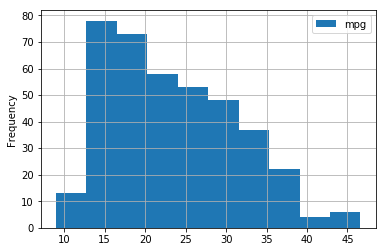

In [19]:
df.plot(kind='hist', y='mpg', grid=True)

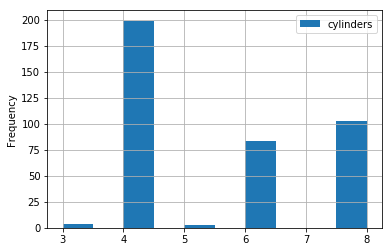

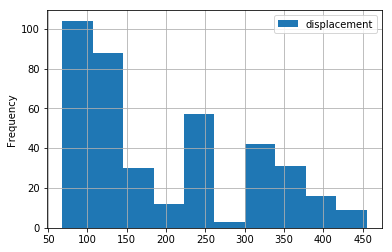

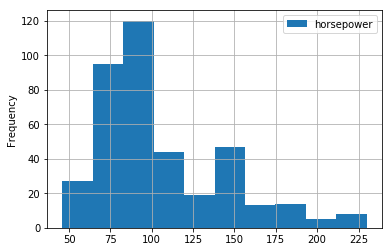

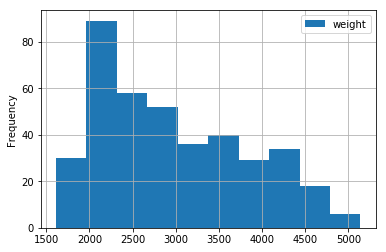

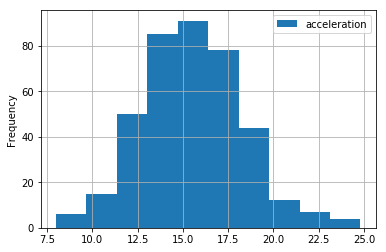

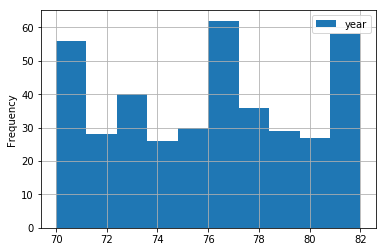

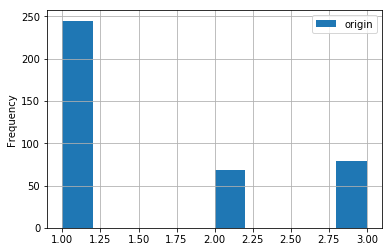

In [20]:
for param in independant_var:
    try:
        df.plot(kind='hist', y=param, grid=True)
    except:
        df[param].value_counts().plot(kind='bar', grid=True)

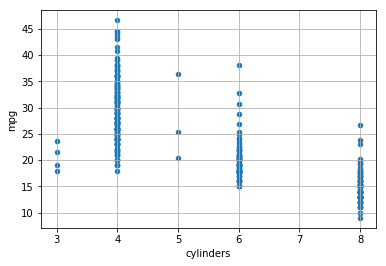

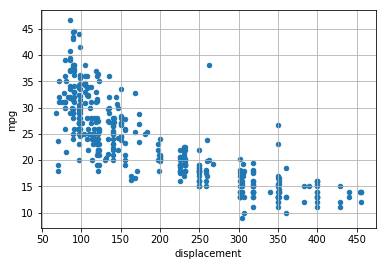

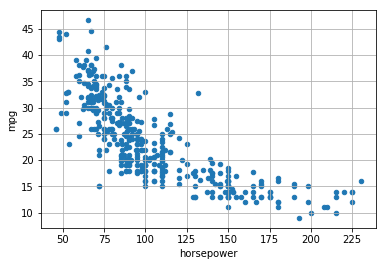

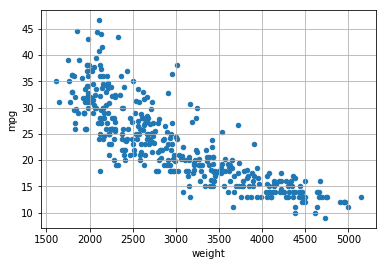

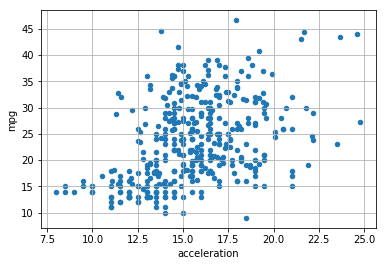

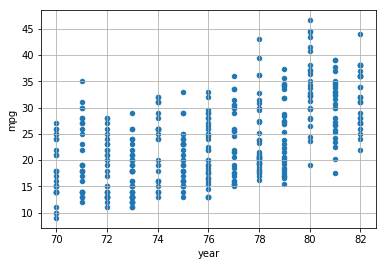

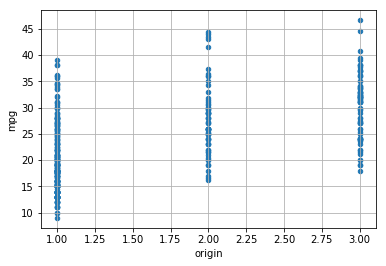

In [21]:
for param in independant_var:
    df.plot(kind='scatter', x=param, y='mpg', grid=True)

# Model
Aim is to model mpg (miles per gallon) from information contained in the dataset

# Tensorflow with lattice

In [22]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc

print(tf.__version__)

2.2.0


In [23]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [306]:
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

In [231]:
train_size = int(len(df) * 0.8)
train_dataframe = df[:train_size]
test_dataframe = df[train_size:]

In [232]:
feature_names = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']
feature_name_indices = {name: index for index, name in enumerate(feature_names)}

In [233]:
# Custom function for extracting each feature.
def extract_features(dataframe,
                     label_name='mpg',
                     feature_names=feature_names):
    features = []
    for feature_name in feature_names:
        features.append(dataframe[feature_name].values.astype(float))
    labels = dataframe[label_name].values.astype(float)
    return features, labels

In [234]:
train_xs, train_ys = extract_features(train_dataframe)
test_xs, test_ys = extract_features(test_dataframe)

In [235]:
# Let's define our label minimum and maximum.
min_label, max_label = float(np.min(train_ys)), float(np.max(train_ys))

In [236]:
def compute_quantiles(features,
                      num_keypoints=10,
                      clip_min=None,
                      clip_max=None,
                      missing_value=None):
    # Clip min and max if desired.
    if clip_min is not None:
        features = np.maximum(features, clip_min)
        features = np.append(features, clip_min)
    if clip_max is not None:
        features = np.minimum(features, clip_max)
        features = np.append(features, clip_max)
    # Make features unique.
    unique_features = np.unique(features)
    # Remove missing values if specified.
    if missing_value is not None:
        unique_features = np.delete(unique_features,
                                    np.where(unique_features == missing_value))
    # Compute and return quantiles over unique non-missing feature values.
    return np.quantile(unique_features,
                       np.linspace(0., 1., num=num_keypoints),
                       interpolation='nearest').astype(float)

In [273]:
n_keypoints = 5
n_lattice = 2
feature_configs = [
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='cylinders',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['cylinders']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='displacement',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['displacement']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='weight',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['weight']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='year',
        monotonicity='increasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['year']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='horsepower',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['horsepower']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='acceleration',
        monotonicity='decreasing',
        # We must set the keypoints manually.
        pwl_calibration_num_keypoints=n_keypoints,
        pwl_calibration_input_keypoints=compute_quantiles(
            train_xs[feature_name_indices['acceleration']],
            num_keypoints=n_keypoints),
    ),
    tfl.configs.FeatureConfig(
        lattice_size=n_lattice,
        name='origin',
        num_buckets=3,
    ),
]

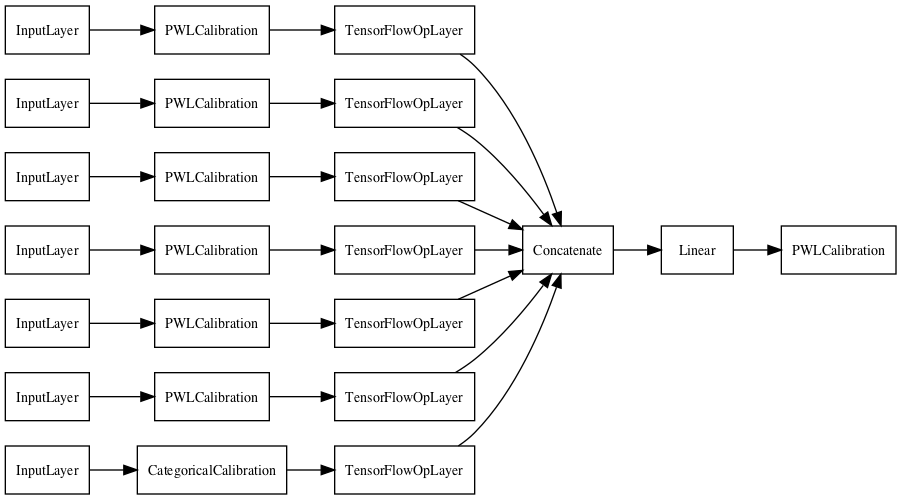

In [274]:
# Model config defines the model structure for the premade model.
linear_model_config = tfl.configs.CalibratedLinearConfig(
    feature_configs=feature_configs,
    use_bias=True,
    # We must set the output min and max to that of the label.
    output_min=min_label,
    output_max=max_label,
    output_calibration=True,
    output_calibration_num_keypoints=10,
    output_initialization=np.linspace(min_label, max_label, num=10),
)
# A CalibratedLinear premade model constructed from the given model config.
linear_model = tfl.premade.CalibratedLinear(linear_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(linear_model, show_layer_names=False, rankdir='LR')

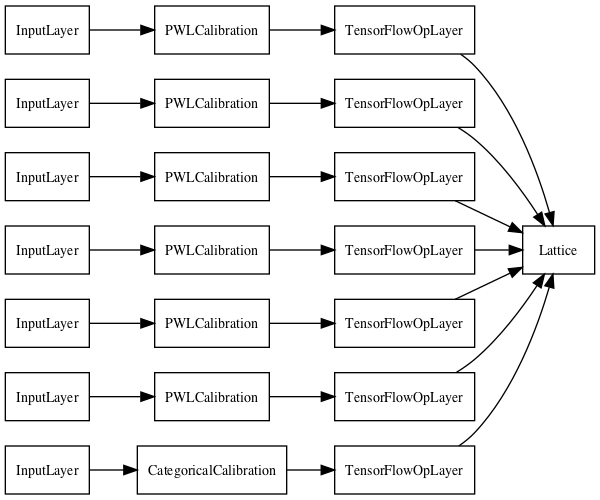

In [275]:
# This is a calibrated lattice model: inputs are calibrated, then combined
# non-linearly using a lattice layer.
lattice_model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs,
    output_min=min_label,
    output_max=max_label,
    output_initialization=[min_label, max_label],
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-2),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-2),
    ])
# A CalibratedLattice premade model constructed from the given model config.
lattice_model = tfl.premade.CalibratedLattice(lattice_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(lattice_model, show_layer_names=False, rankdir='LR')

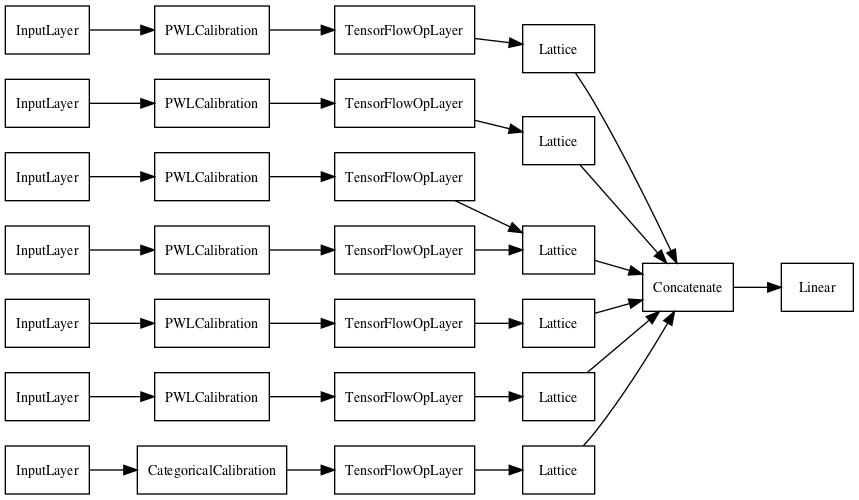

In [276]:
feature_names = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
explicit_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices=[['weight', 'horsepower'], ['cylinders'],
              ['displacement'], ['year'], ['acceleration'], ['origin']],
    output_min=min_label,
    output_max=max_label,
    output_initialization=[min_label, max_label],
    use_linear_combination=True,
)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
explicit_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    explicit_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    explicit_ensemble_model, show_layer_names=False, rankdir='LR')

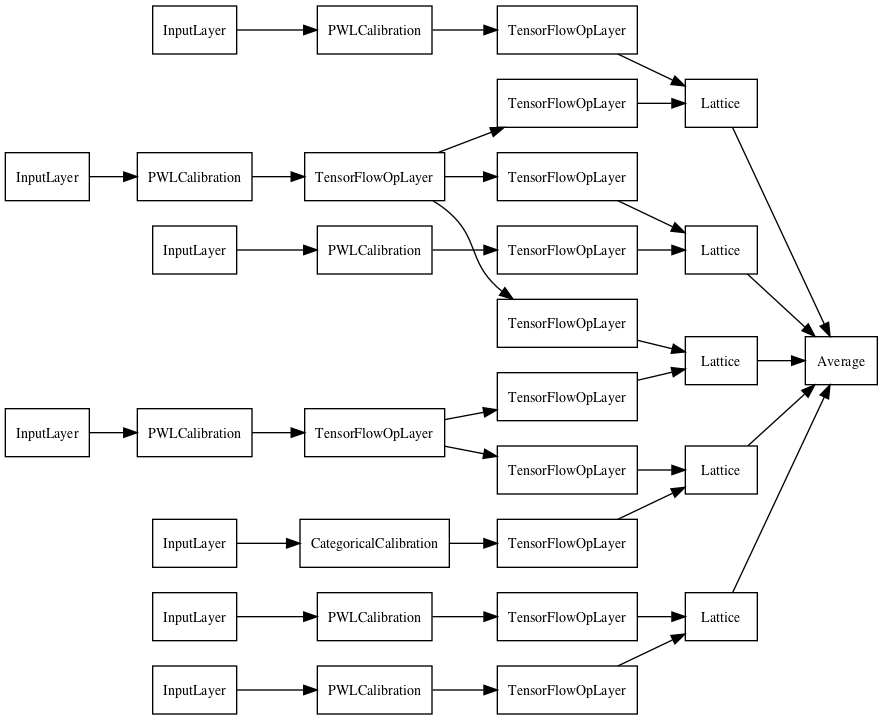

In [285]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
random_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='random',
    num_lattices=5,
    lattice_rank=2,
    output_min=min_label,
    output_max=max_label,
    output_initialization=[min_label, max_label],
    random_seed=42)
# Now we must set the random lattice structure and construct the model.
tfl.premade_lib.set_random_lattice_ensemble(random_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
random_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    random_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    random_ensemble_model, show_layer_names=False, rankdir='LR')

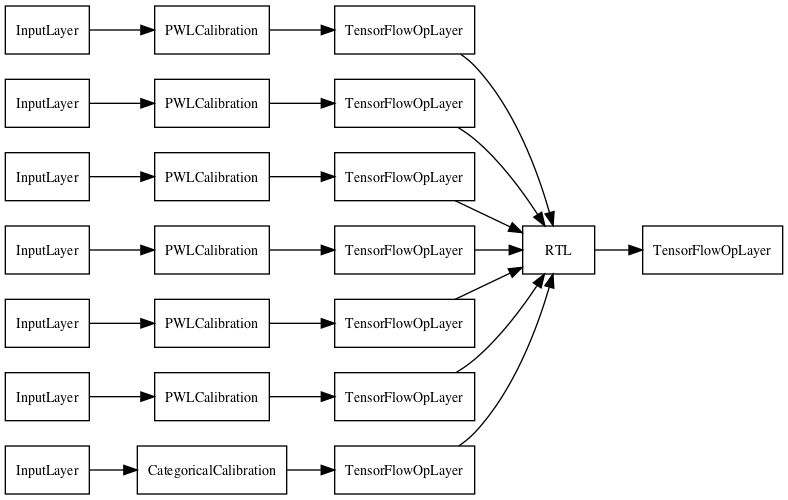

In [296]:
import copy
# Make sure our feature configs have the same lattice size, no per-feature
# regularization, and only monotonicity constraints.
rtl_layer_feature_configs = copy.deepcopy(feature_configs)
for feature_config in rtl_layer_feature_configs:
  feature_config.lattice_size = 2
  feature_config.unimodality = 'none'
  feature_config.reflects_trust_in = None
  feature_config.dominates = None
  feature_config.regularizer_configs = None
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combined non-linearly and averaged using multiple lattice layers.
rtl_layer_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=rtl_layer_feature_configs,
    lattices='rtl_layer',
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label,
    output_initialization=[min_label, max_label],
    random_seed=42)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config. Note that we do not have to specify the lattices by calling
# a helper function (like before with random) because the RTL Layer will take
# care of that for us.
rtl_layer_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    rtl_layer_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    rtl_layer_ensemble_model, show_layer_names=False, rankdir='LR')

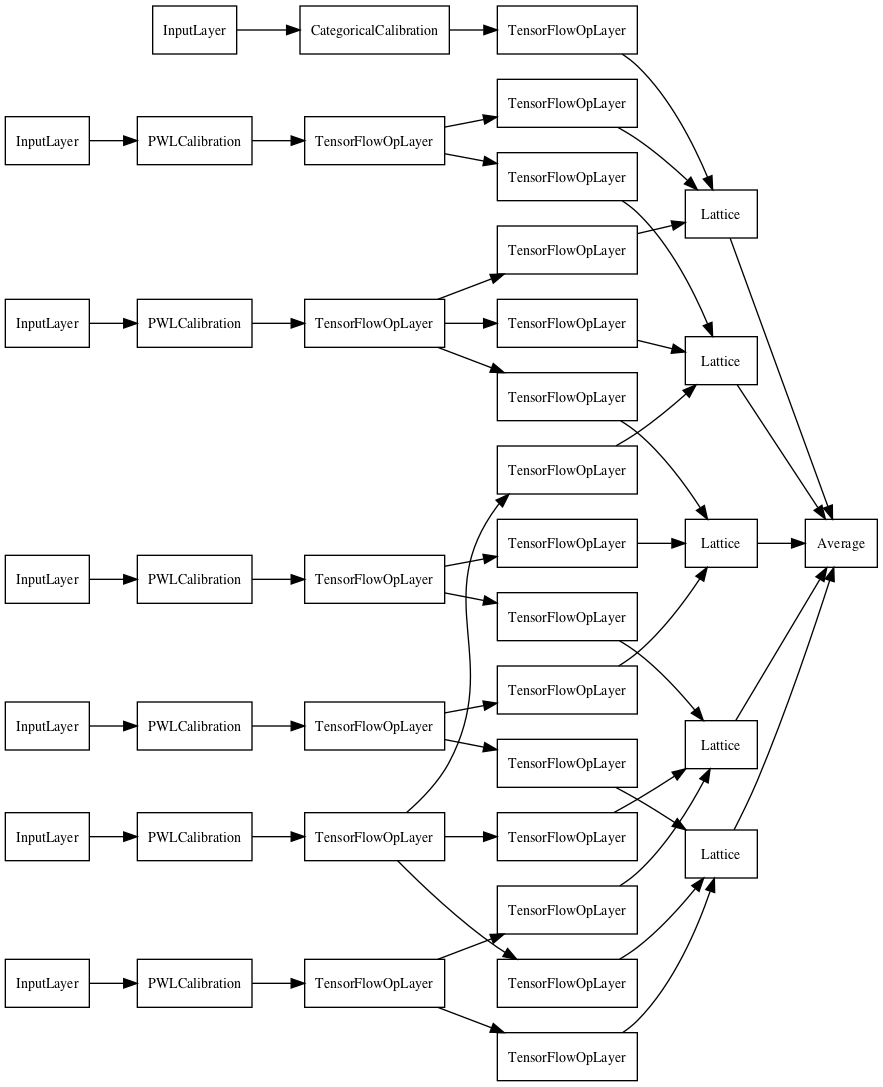

In [308]:
# This is a calibrated lattice ensemble model: inputs are calibrated, then
# combines non-linearly and averaged using multiple lattice layers.
crystals_ensemble_model_config = tfl.configs.CalibratedLatticeEnsembleConfig(
    feature_configs=feature_configs,
    lattices='crystals',
    num_lattices=5,
    lattice_rank=3,
    output_min=min_label,
    output_max=max_label,
    output_initialization=[min_label, max_label],
    random_seed=42)
# Now that we have our model config, we can construct a prefitting model config.
prefitting_model_config = tfl.premade_lib.construct_prefitting_model_config(
    crystals_ensemble_model_config)
# A CalibratedLatticeEnsemble premade model constructed from the given
# prefitting model config.
prefitting_model = tfl.premade.CalibratedLatticeEnsemble(
    prefitting_model_config)
# We can compile and train our prefitting model as we like.
prefitting_model.compile(
    loss='mse',
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE))
prefitting_model.fit(
    train_xs,
    train_ys,
    epochs=PREFITTING_NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=False)
# Now that we have our trained prefitting model, we can extract the crystals.
tfl.premade_lib.set_crystals_lattice_ensemble(crystals_ensemble_model_config,
                                              prefitting_model_config,
                                              prefitting_model)
# A CalibratedLatticeEnsemble premade model constructed from the given
# model config.
crystals_ensemble_model = tfl.premade.CalibratedLatticeEnsemble(
    crystals_ensemble_model_config)
# Let's plot our model.
tf.keras.utils.plot_model(
    crystals_ensemble_model, show_layer_names=False, rankdir='LR')

In [309]:
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10)
epoch_dots = tfdocs.modeling.EpochDots(report_every=10, dot_every=1)

In [319]:
model = explicit_ensemble_model

In [320]:
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9, nesterov=True),  # Optimizer
    # Loss function to minimize
    loss='mse',
    # List of metrics to monitor
    metrics=['mse', 'mae'],
)

In [321]:
history = model.fit(
    train_xs,
    train_ys,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(test_xs, test_ys),
    shuffle=False,
    verbose=0,
    callbacks=[early_stopping, epoch_dots])


Epoch: 0, loss:5.2836,  mae:1.7046,  mse:5.2836,  val_loss:17.9784,  val_mae:3.1473,  val_mse:17.9784,  
..........
Epoch: 10, loss:5.2265,  mae:1.6919,  mse:5.2265,  val_loss:18.1257,  val_mae:3.1602,  val_mse:18.1257,  
.......

In [322]:
model.summary()

Model: "calibrated_lattice_ensemble_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tfl_input_weight (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
tfl_input_horsepower (InputLaye [(None, 1)]          0                                            
__________________________________________________________________________________________________
tfl_input_cylinders (InputLayer [(None, 1)]          0                                            
__________________________________________________________________________________________________
tfl_input_displacement (InputLa [(None, 1)]          0                                            
______________________________________________________________________

(0, 20)

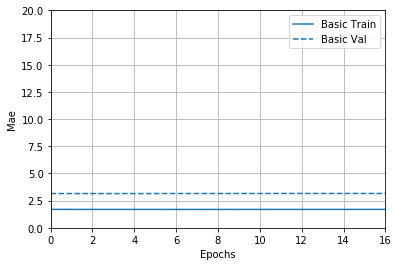

In [323]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 20])

In [324]:
from sklearn.metrics import mean_squared_error, r2_score

df['MPG_pred'] = model.predict(extract_features(df))
df['MPG_error'] = df['MPG_pred'] - df['mpg']

print(
    'scores\nmse={:.2f}\nr2={:.2f}\n'.\
    format(mean_squared_error(df['MPG_pred'], df['mpg']),
           r2_score(df['MPG_pred'], df['mpg'])
          )
)

scores
mse=7.75
r2=0.85



/Users/thomas/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


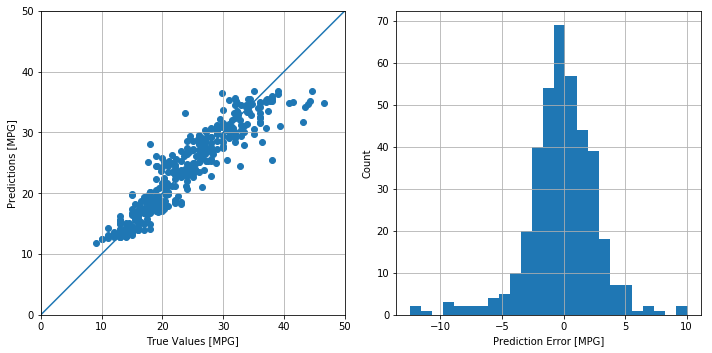

In [325]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))

ax[0].scatter(df['mpg'], df['MPG_pred'])
ax[0].set_xlabel('True Values [MPG]')
ax[0].set_ylabel('Predictions [MPG]')
lims = [0, 50]
ax[0].set_xlim(lims)
ax[0].set_ylim(lims)
ax[0].plot(lims, lims)
ax[0].set_aspect('equal')
ax[0].grid('on')

ax[1].hist(df['MPG_error'], bins = 25)
ax[1].set_xlabel("Prediction Error [MPG]")
ax[1].set_ylabel("Count")
#ax[1].set_aspect('equal')
ax[1].grid('on')

plt.tight_layout()

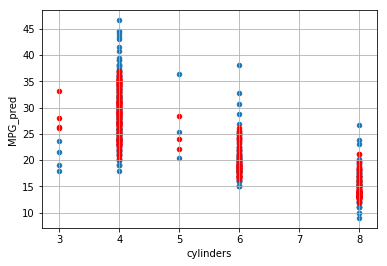

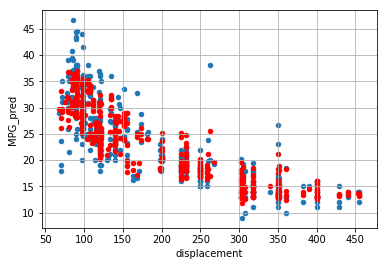

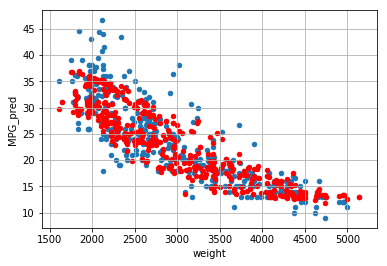

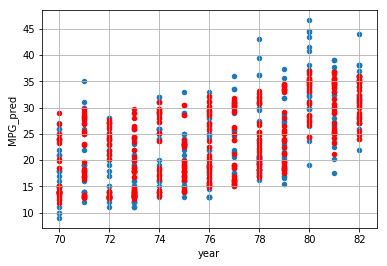

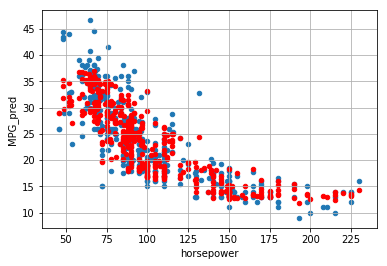

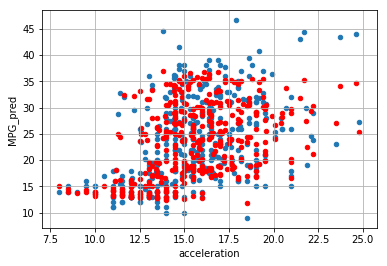

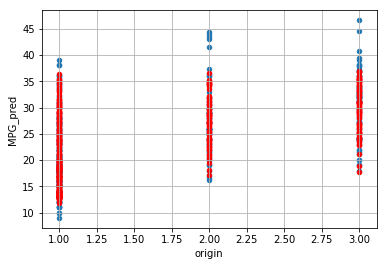

In [326]:
for param in [feature.key for feature in feature_columns]:
    ax = df.plot(kind='scatter', x=param, y='mpg', grid=True)
    df.plot(kind='scatter', x=param, y='MPG_pred', grid=True, ax=ax, c='r')

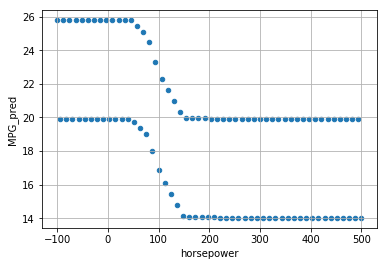

In [327]:
df_tmp = pd.DataFrame()
main_independant_var = ['cylinders', 'displacement', 'weight', 'year', 'horsepower', 'acceleration', 'origin']


df_tmp['cylinders'] = [6]*100#np.linspace(0, 10, 100)#
df_tmp['displacement'] = 250#np.linspace(0, 500, 100)#200
df_tmp['weight'] = [0, 4000]*50#np.linspace(0, 10000, 100)#[5000]*100
df_tmp['year'] = 70#[70, 80]*50
df_tmp['horsepower'] = np.linspace(-100, 500, 100)
df_tmp['acceleration'] = 15#np.linspace(0, 30, 100)#20
df_tmp['origin'] = 1
df_tmp['mpg'] = 0

df_tmp['MPG_pred'] = model.predict(extract_features(df_tmp))

ax = df_tmp.plot(kind='scatter', x='horsepower', y='MPG_pred', grid=True)